<a href="https://colab.research.google.com/github/munjaehyeok/DDIM-/blob/main/DDIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. import

In [18]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

import keras
from keras import layers
from keras import ops

# 2. data, parameter

In [19]:
# data
dataset_name = "oxford_flowers102"
#dataset_repetitions = 5
dataset_repetitions = 5
num_epochs = 50  # train for at least 50 epochs for good results
image_size = 64

# KID = Kernel Inception Distance, see related section
kid_image_size = 75
kid_diffusion_steps = 5
plot_diffusion_steps = 20

# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95

# architecture
embedding_dims = 32
embedding_max_frequency = 1000.0
widths = [32, 64, 96, 128]
block_depth = 2

# optimization
batch_size = 64
ema = 0.999
learning_rate = 1e-3
weight_decay = 1e-4

# 데이터 전처리

In [20]:

def preprocess_image(data):
    # center crop image
    height = ops.shape(data["image"])[0]
    width = ops.shape(data["image"])[1]
    crop_size = ops.minimum(height, width)
    image = tf.image.crop_to_bounding_box(
        data["image"],
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    )

    # resize and clip
    # for image downsampling it is important to turn on antialiasing
    image = tf.image.resize(image, size=[image_size, image_size], antialias=True)
    return ops.clip(image / 255.0, 0.0, 1.0)


def prepare_dataset(split):
    # the validation dataset is shuffled as well, because data order matters
    # for the KID estimation
    return (
        tfds.load(dataset_name, split=split, shuffle_files=True)
        .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        .cache()
        .repeat(dataset_repetitions)
        .shuffle(10 * batch_size)
        .batch(batch_size, drop_remainder=True)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )


# load dataset
train_dataset = prepare_dataset("train[:80%]+validation[:80%]+test[:80%]")
val_dataset = prepare_dataset("train[80%:]+validation[80%:]+test[80%:]")


# KID 구현

In [21]:

@keras.saving.register_keras_serializable()
class KID(keras.metrics.Metric):
    def __init__(self, name, **kwargs):
        super().__init__(name=name, **kwargs)

        # KID is estimated per batch and is averaged across batches
        self.kid_tracker = keras.metrics.Mean(name="kid_tracker")

        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        self.encoder = keras.Sequential(
            [
                keras.Input(shape=(image_size, image_size, 3)),
                layers.Rescaling(255.0),
                layers.Resizing(height=kid_image_size, width=kid_image_size),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, 3),
                    weights="imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        feature_dimensions = ops.cast(ops.shape(features_1)[1], dtype="float32")
        return (
            features_1 @ ops.transpose(features_2) / feature_dimensions + 1.0
        ) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel(
            generated_features, generated_features
        )
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = real_features.shape[0]
        batch_size_f = ops.cast(batch_size, dtype="float32")
        mean_kernel_real = ops.sum(kernel_real * (1.0 - ops.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = ops.sum(
            kernel_generated * (1.0 - ops.eye(batch_size))
        ) / (batch_size_f * (batch_size_f - 1.0))
        mean_kernel_cross = ops.mean(kernel_cross)
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # update the average KID estimate
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()

@keras.saving.register_keras_serializable()
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = ops.exp(
        ops.linspace(
            ops.log(embedding_min_frequency),
            ops.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = ops.cast(2.0 * math.pi * frequencies, "float32")
    embeddings = ops.concatenate(
        [ops.sin(angular_speeds * x), ops.cos(angular_speeds * x)], axis=3
    )
    return embeddings



# U-net

In [22]:

def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3] #x: shape = (batch_size, height, width, input_channels)
        if input_width == width: #채널 수 맞추기
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x) #1x1로 채널 수 맞추기

        x = layers.BatchNormalization(center=False, scale=False)(x)#배치 정규화 평균0 분산1
        x = layers.Conv2D(width, kernel_size=3, padding="same", activation="swish")(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual]) # 잔차 연결

        return x

    return apply


def DownBlock(width, block_depth): #채널 #2
    def apply(x):
        x, skips = x
        for _ in range(block_depth): #2번 수행
            x = ResidualBlock(width)(x)
            skips.append(x) #skips에 저장 나중에 concate에 사용

        x = layers.AveragePooling2D(pool_size=2)(x) # 풀링

        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()]) #여기서 skip 꺼내서 concate수행
            x = ResidualBlock(width)(x)

        return x
    return apply

def get_network(image_size, widths, block_depth):
    # 이미지의 가로/세로 크기, 채널 수 리스트,각 단계마다 residual block 몇 개 쓸지
    noisy_images = keras.Input(shape=(image_size, image_size, 3)) #노이즈가 섞인 RGB 이미지 (입력)
    noise_variances = keras.Input(shape=(1, 1, 1))#이미지에 추가된 노이즈의 강도 (시간정보 t에 해당)

    e = layers.Lambda(sinusoidal_embedding, output_shape=(1, 1, 32))(noise_variances)
    #noise_variances를 sinusoidal embedding으로 변환 (32채널)
    e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)
    #(1, 1, 32) → (image_size, image_size, 32)로 확장

    ###인코더###
    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)#e와 맞춰서 크기 채널수 맞춰줌
    x = layers.Concatenate()([x, e]) #임베딩 정보 더해줌

    skips = []
    for width in widths[:-1]: #width [32,64,128,256]#마지막 제외
        x = DownBlock(width, block_depth)([x, skips]) #채널 수 넣어주며 대운블럭 수행
    ###중앙###
    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)
    ###디코더###
    for width in reversed(widths[:-1]):  #width [32,64,128,256]#처음 제외
        x = UpBlock(width, block_depth)([x, skips]) #apply(x,skips)
    ###출력###
    x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)
    #채널 수 3 RGB // 처음에는 아무 정보 없으므로 → 가중치를 0으로 초기화해서, 모델 시작 시 출력이 0에 가까움

    ###모델 생성###
    return keras.Model([noisy_images, noise_variances], x, name="residual_unet") # 입력, 출력, 이름


# diffusion model

In [23]:

@keras.saving.register_keras_serializable()
class DiffusionModel(keras.Model):
    def __init__(self, image_size, widths, block_depth):
        super().__init__()
        # 입력 이미지를 정규화하기 위한 레이어 (mean=0, std=1 형태로 변환)
        self.normalizer = layers.Normalization()
        # U-Net 기반의 주 네트워크 구조 생성
        self.network = get_network(image_size, widths, block_depth)
        # EMA(지수이동평균) 네트워크: 학습이 완료된 안정된 파라미터를 추론 시 사용
        # U-net과 똑같은 모델을 하나 더만듦
        self.ema_network = keras.models.clone_model(self.network)

    def compile(self, **kwargs): #**kwargs 는 딕셔너리로 처리
        '''
        kwargs = {
        'optimizer': AdamW(...),
        'loss': MeanSquaredError()
        }
        '''
        super().compile(**kwargs)# keras의 optimizer, loss를 그대로 사용
        # 노이즈 손실 추적: 예측된 노이즈가 실제 노이즈와 얼마나 가까운지 평균 손실 기록
        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        # 이미지 복원 성능 추적용 메트릭: 복원 이미지가 원본과 얼마나 가까운지 평균 손실 기록
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")
        # 이미지 생성 품질 평가를 위한 KID (Kernel Inception Distance)
        self.kid = KID(name="kid")
    @property
    def metrics(self):
        # 모델이 추적하는 리스트 반환
        return [self.noise_loss_tracker, self.image_loss_tracker, self.kid]

    def denormalize(self, images):
        # 정규화된 이미지를 원래 스케일(픽셀값 0~1 범위)로 복원
        # 정규화 과정: normalized = (original - mean) / std
        # 역정규화: original = mean + normalized * std
        # 여기서 std = sqrt(variance)
        images = self.normalizer.mean + images * self.normalizer.variance**0.5 #역정규화
        #이렇게 복원된 픽셀 값들이 0~1 범위를 넘을 수 있기 때문에, 클리핑으로 안정성 확보를 합니다.
        return ops.clip(images, 0.0, 1.0)

    def diffusion_schedule(self, diffusion_times):
        # diffusion times -> angles
        #t에 따른 신호(알파)와 노이즈(베타 = 1-알파)를 사인 코사인으로 구현
        #max_signal_rate와 min_signal_rate는 사전에 설정된 신호 비율의 최대/최소값입니다.
        #각 신호 비율에 대응하는 각도를 역삼각함수 arccos를 이용해 구합니다.
        #각도를 float32 타입으로 변환합니다.
        #최대 신호 비율에 대응하는 작은 각도
        start_angle = ops.cast(ops.arccos(max_signal_rate), "float32")
        #across(역코사인)는 각도,cast는 float32로 맞춤
        #최소 신호 비율에 대응하는 큰 각도
        end_angle = ops.cast(ops.arccos(min_signal_rate), "float32")

        #선형으로 표현해서 t일 때 각도를 구함
        #t=0이면 diffusion_angles = start_angle,
        #t=1이면 diffusion_angles = end_angle이 되도록 선형적으로 값을 계산합니다.
        diffusion_angles = (end_angle - start_angle) *  diffusion_times + start_angle

        # 삼각함수로 알파와 베타, 원본 비율, 노이즈 비율을 구함
        signal_rates = ops.cos(diffusion_angles)
        noise_rates = ops.sin(diffusion_angles)
        # note that their squared sum is always: sin^2(x) + cos^2(x) = 1

        return noise_rates, signal_rates

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        # the exponential moving average weights are used at evaluation
        # 학습 중이면 self.network (현재 가중치 사용), 평가 시엔 self.ema_network (EMA 가중치 사용)
        if training:
            network = self.network
        else:
            network = self.ema_network
        # 노이즈 예측: 네트워크는 noisy_images와 noise_rates**2를 입력받아 노이즈 성분을 예측함
        pred_noises = network([noisy_images, noise_rates**2], training=training) #u net사용
        # 예측된 노이즈를 사용해 원래 이미지를 복원 (추정)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        #완전한 가우시안 노이즈,몇 단계로 역확산을 수행할지 설정
        #intial_noise.shape=(num_images, H, W, C)
        # reverse diffusion = sampling
        num_images = initial_noise.shape[0] # 배치 크기 (생성할 이미지 개수)
        step_size = 1.0 / diffusion_steps

        # important line:
        # at the first sampling step, the "noisy image" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_images = initial_noise #랜덤 가우시안 노이즈에서 시작
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images

            # separate the current noisy image to its components
            #현재 시점의 t 계산, 1에서 시작해서 점점 줄어듦
            diffusion_times = ops.ones((num_images, 1, 1, 1)) - step * step_size
            #현재시점의 노이즈 비율 계산
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            #노이즈 비율을 가지고 이미지와 노이즈 분리
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=False
            )
            # network used in eval mode
            #다음 스텝 준비
            # remix the predicted components using the next signal and noise rates
            #다음 t시점
            next_diffusion_times = diffusion_times - step_size
            #다음 스텝 노이즈 비율
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            #다음 노이즈 상태t-1 이미지 만들기, 예측한 x0이미지에 이전 노이즈를 살짝 섞음
            next_noisy_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
            # this new noisy image will be used in the next step

        return pred_images
    #위에 denoise 사용해서 생성
    def generate(self, num_images, diffusion_steps):
        # noise -> images -> denormalized images
        # 랜던 노이즈 설정
        initial_noise = keras.random.normal(
            shape=(num_images, image_size, image_size, 3)
        )
        #출력은 정규화된 이미지 (픽셀 값이 평균 0, 표준편차 1 범위)
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
        #정규화된 값을 원래 스케일(0~1 범위)로 되돌립니다.
        generated_images = self.denormalize(generated_images)
        return generated_images

    def train_step(self, images):#한 배치의 images를 입력으로 받음
        # normalize images to have standard deviation of 1, like the noises
        #이미지 정규화 평균 0, 표준편차 1
        images = self.normalizer(images, training=True)
        #동일한 크기의 가우시안 노이즈 샘플을 생성
        noises = keras.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        # 랜덤 시점 t 선택
        diffusion_times = keras.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        #t시점의 노이즈 와 원본 비율 계산
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        #노이즈 낀 이미지 생성
        noisy_images = signal_rates * images + noise_rates * noises

        #예측과 손실 계산
        with tf.GradientTape() as tape: #tensorflow의 자동 미분 기능 사용 문법
            # train the network to separate noisy images to their components
            #이미지의 섞여있는 노이즈 예측, 노이즈 제거한 이미지x0
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )
            #실제 노이즈와 예측한 노이즈의 차이 계산
            noise_loss = self.loss(noises, pred_noises)  # used for training
            #학습에는 사용되지않지만 이미지의 차이 정도를 보기 위함
            image_loss = self.loss(images, pred_images)  # only used as metric

        #역전파로 파라미터 업데이트(noise_loss기준)
        #gradients 계산
        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        #gradients를 통해 가중치 갱신
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        #손실을 Keras 메트릭 시스템에 저장(모니터링 위함)
        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        # track the exponential moving averages of weights
        # EMA 네트워크 업데이트
        #학습 중에는 네트워크 가중치가 요동치므로 안정적인 추론용 파라미터를 유지하기 위해 EMA 버전을 따로 관리
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)

        # KID is not measured during the training phase for computational efficiency
        # 추적 중인 메트릭 리스트 반환 noise_loss_tracker, image_loss_tracker,KID제외(계산 비용이 큼)
        #반환값은 딕셔너리 형태:
        """{
        "n_loss": 평균 노이즈 손실,
        "i_loss": 평균 이미지 손실

        """
        return {m.name: m.result() for m in self.metrics[:-1]}

    def test_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        #입력 이미지 정규화
        images = self.normalizer(images, training=False)
        #가우시안 노이즈 생성
        noises = keras.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        #랜덤 타임 t설정
        diffusion_times = keras.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        #t에 따른 노이즈,신호 비율 계산
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        #노이즈 이미지 생성
        noisy_images = signal_rates * images + noise_rates * noises

        # use the network to separate noisy images to their components
        #예측 수행: 예측 노이즈, 예측 이미지
        #training = False로 EMA네트워크 이용
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, training=False
        )
        #손실 계산: 노이즈와 이미지 로스
        noise_loss = self.loss(noises, pred_noises)
        image_loss = self.loss(images, pred_images)
        #로스값 업데이트
        self.image_loss_tracker.update_state(image_loss)
        self.noise_loss_tracker.update_state(noise_loss)
        #KID측정
        # measure KID between real and generated images
        # this is computationally demanding, kid_diffusion_steps has to be small
        #images는 정규화된 상태 => 원래 픽셀값으로 복원
        images = self.denormalize(images)
        #새로운 이미지 생성 (일반적으로 전체 diffusion step보다 더 작게 설정하여 빠르게 생성.)
        generated_images = self.generate(
            num_images=batch_size, diffusion_steps=kid_diffusion_steps
        )
        self.kid.update_state(images, generated_images)
        #현재까지 추적된 noise_loss, image_loss, kid 값을 반환
        return {m.name: m.result() for m in self.metrics}
    def plot_images(self, epoch=None, logs=None, num_rows=3, num_cols=6):
        # plot random generated images for visual evaluation of generation quality
        # 디렉토리 없으면 생성
        os.makedirs("samples", exist_ok=True)

        generated_images = self.generate(
            num_images=num_rows * num_cols,
            diffusion_steps=plot_diffusion_steps,
        )

        plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
        for row in range(num_rows):
            for col in range(num_cols):
                index = row * num_cols + col
                plt.subplot(num_rows, num_cols, index + 1)
                plt.imshow(generated_images[index])
                plt.axis("off")
        plt.tight_layout()
        plt.savefig(f"samples/generated_epoch_{epoch}.png")
        plt.close()


# 실행

In [24]:

# create and compile the model
model = DiffusionModel(image_size, widths, block_depth)
# below tensorflow 2.9:
# pip install tensorflow_addons
# import tensorflow_addons as tfa

# optimizer=tfa.optimizers.AdamW
#모델을 학습 준비 상태로 만듦
model.compile(
    optimizer=keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.mean_absolute_error,
)
###
model.build(input_shape=[(1, 64, 64, 3), (1, 1, 1, 1)])
###
# pixelwise mean absolute error is used as loss

# save the best model based on the validation KID metric
#학습 중 가장 validation KID 값이 낮을 때 모델 가중치 저장
checkpoint_path = "checkpoints/diffusion_model.weights.h5"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,#전체 모델이 아닌 가중치만 저장
    monitor="val_kid", #검증용 KID 지표를 기준으로
    mode="min",#최소기준
    save_best_only=True,
)
#정규화를 위한 평균/분산 학습
#Normalization() 레이어는 데이터를 (평균 0, 표준편차 1)로 표준화합니다.
#adapt()는 훈련 데이터를 기준으로 평균/분산을 계산합니다.
# calculate mean and variance of training dataset for normalization
model.normalizer.adapt(train_dataset)

#모델 학습
# run training and plot generated images periodically
model.fit(
    train_dataset,#학습 데이터셋
    epochs=num_epochs,# 검증용 데이터셋
    validation_data=val_dataset,#학습 반복 횟수
    callbacks=[
        # 매 에폭이 끝날 때마다 이미지를 생성해 시각화함
        keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images),
        #가장 성능 좋은 모델 가중치를 저장
        checkpoint_callback,
    ],
)
print("학습 종료")
#가장 좋은 가중치 로드
# load the best model and generate images
#model.load_weights(checkpoint_path)
#이미지 생성
#model.plot_images()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'diffusion_model_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Epoch 1/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 176s 288ms/step - i_loss: 0.6892 - n_loss: 0.2847 - val_i_loss: 2.4976 - val_kid: 2.0275 - val_n_loss: 0.7908
Epoch 2/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 128s 251ms/step - i_loss: 0.2955 - n_loss: 0.1712 - val_i_loss: 2.2853 - val_kid: 1.8931 - val_n_loss: 0.7299
Epoch 3/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 128s 251ms/step - i_loss: 0.2761 - n_loss: 0.1623 - val_i_loss: 1.8880 - val_kid: 1.5901 - val_n_loss: 0.6053
Epoch 4/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 128s 251ms/step - i_loss: 0.2685 - n_loss: 0.1588 - val_i_loss: 1.3004 - val_kid: 1.3647 - val_n_loss: 0.4633
Epoch 5/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 126s 246ms/step - i_loss: 0.2603 - n_loss: 0.1559 - val_i_loss: 0.9131 - val_kid: 1.4847 - val_n_loss: 0.3426
Epoch 6/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 126s 247ms/step - i_loss: 0.2542 - n_loss: 0.1541 - val_i_loss: 0.6324 - val_kid: 1.4832 - val_n_loss: 0.2582
Epoch 7/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 127s 248ms/step - i_loss: 0.2535 - n_loss: 0.1535 - val_i_lo

# 샘플링


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'diffusion_model_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 162 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


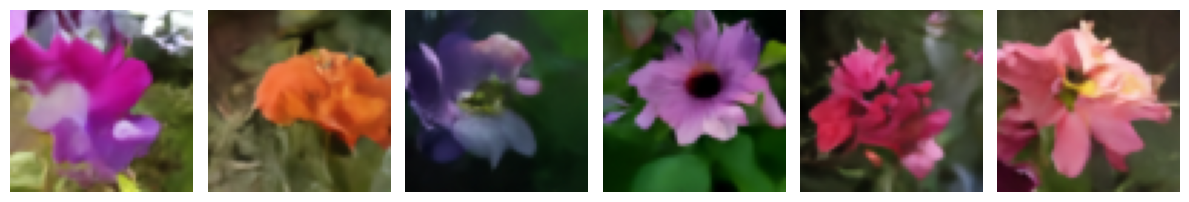

In [25]:
# sample_only.py

import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
from keras import optimizers, losses

# ddim.py에서 필요한 것만 import
from ddim import DiffusionModel, image_size, widths, block_depth, plot_diffusion_steps

# 1. 모델 생성 및 컴파일
model = DiffusionModel(image_size, widths, block_depth)
model.compile(
    optimizer=optimizers.AdamW(),  # 옵티마이저는 샘플링에는 영향 없음
    loss=losses.mean_absolute_error
)

# 2. 입력 shape 명시적으로 빌드 (가중치 로드 전에 반드시!)
model.build(input_shape=[(1, image_size, image_size, 3), (1, 1, 1, 1)])

# 3. normalizer에 평균/분산 초기화 (정규화 복원을 위해 필요함)
#     → train[:1]에서 하나만 가져와도 충분
dummy_dataset = (
    tfds.load("oxford_flowers102", split="train[:1]")
    .map(lambda x: tf.image.resize(x["image"], [image_size, image_size]))
    .map(lambda x: tf.cast(x, tf.float32) / 255.0)
    .batch(1)
)
model.normalizer.adapt(dummy_dataset)

# 4. 가중치 로드
model.load_weights("checkpoints/diffusion_model.weights.h5")

# 5. 이미지 생성
generated_images = model.generate(num_images=6, diffusion_steps=plot_diffusion_steps)

# 6. 시각화 및 저장
plt.figure(figsize=(12, 4))
for i in range(6):
    plt.subplot(1, 6, i + 1)
    plt.imshow(generated_images[i])
    plt.axis("off")
plt.tight_layout()
os.makedirs("samples", exist_ok=True)
plt.savefig("samples/generated_from_ddim_only.png")
plt.show()# sample_only.py
